# Классификация облаков

Продолжение с повышением качества модели. 
Это эксперементальный вариант. 
Данный код уже был изменен с помощью ChatGPT, который предложил внести изменения в структуру энкодеров-декодеров
и Loss-функции в соответствии со своими представлениями.
Так же повышена вычислительная мощность модели, использовано для обучения полная выборка, вместо 10% в прошлой задаче, 
размеры обучающих фотографий увеличены до 256х256, количество эпох - 15 и проведение обучения в облачной инфраструктуре на мощных видеокартах.

In [1]:
# preload local libs
import sys
import os
import pathlib

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [2]:
data_dir = '/HDD/usr/dionx/КУРСЫ/OTUS'
data_train_img_dir = data_dir + '/train_images'
data_test_img_dir = data_dir + '/test_images'
data_train_img_dir_resampled = data_dir + '/train_images/resampled'
data_train_csv = data_dir + '/train.csv'

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader, random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm

import pandas as pd
import numpy as np

from PIL import Image
import random

NUM_WORKERS = 8
BATCH_SIZE = 96
SHAPE = (1400, 2100)
# RESIZED = (350, 525)
RESIZED = (256, 256)
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'

Считываем метки

In [4]:
df = pd.read_csv(data_train_csv)
df[['Image', 'Class']] = df['Image_Label'].str.rsplit('_', n=1).tolist()

#### Метод декодирования RLE

In [5]:
def rle_decode(rle_string, shape=SHAPE):
    """
    Декодирует маску из RLE-формата (Run-Length Encoding) в 2D-массив.
    
    Параметры:
        encoded_pixels: строка с чередующимися стартовыми позициями и длинами (1-based)
        shape: tuple (height, width) — размер выходной маски
    
    Возвращает:
        np.ndarray формы shape с типом uint8 (1 — пиксель объекта, 0 — фон)
    """
    # Обработка NaN или пустых значений
    if isinstance(rle_string, float) and math.isnan(rle_string):
        return np.zeros(shape, dtype=np.uint8, order='F')
    
    if not rle_string or rle_string == '':  # пустая строка или None
        return np.zeros(shape, dtype=np.uint8, order='F')
    
    # Разбиваем строку на список чисел (как строки)
    parts = rle_string.split()
    
    # Преобразуем в массивы, используя np.asarray
    starts = np.asarray(parts[0::2], dtype=np.int64) - 1      # 1-based → 0-based
    lengths = np.asarray(parts[1::2], dtype=np.int64)
    
    # Создаём плоский массив нужного размера
    flat_mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    # Заполняем интервалы значением 1
    for start, end in zip(starts, starts + lengths):
        flat_mask[start:end] = 1
    
    # Возвращаем в нужной форме с Fortran-order (по столбцам), как в оригинале
    return flat_mask.reshape(shape, order='F')

#### Аугментация

In [6]:
# использоуется albumentations так как нужны синхронные преобразоания изображения с маской
train_transform = A.Compose([
        A.Resize(height=RESIZED[0], width=RESIZED[1]), # ресайз до фиксированного размера
        A.HorizontalFlip(p=0.5),                       # случайное горизонтальное отражение
        A.Rotate(limit=30, p=0.5, interpolation=cv2.INTER_NEAREST), # рандомно поворачиваем. interpolation для Dice
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # RGB # type: ignore
        # A.Normalize(mean=[0.5], std=[0.5]),            # нормализация для 1-канального grayscale # type: ignore
        ToTensorV2(),                                  # конвертация в тензор PyTorch
    ]
)
# Для тестовой выборки другой набор преобразований
test_transform = A.Compose([
        A.Resize(height=RESIZED[0], width=RESIZED[1]), # ресайз до фиксированного размера
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # RGB # type: ignore
        ToTensorV2(),                                  # конвертация в тензор PyTorch
    ]
)

#### DataSet и DataLoader

Разделим для наглядности на 4 разных класса. Это меняет тип задачи на классическую задачу семантической сегментации.

Была идея оставить в обучающей выборке только фотографии с непустой маской.\
Однако, такой вариант не был рекомендован 
из-за того, что сеть не научится определять фотографии, где нет искомого типа облаков. 

Таки образом:

In [7]:
df_fish = df[df['Class'] == 'Fish'].reset_index(drop=True)
df_flower = df[df['Class'] == 'Flower'].reset_index(drop=True)
df_gravel = df[df['Class'] == 'Gravel'].reset_index(drop=True)
df_sugar = df[df['Class'] == 'Sugar'].reset_index(drop=True)

Определяем CloudDataset, который будет получать на вход набор даных только одного из классов

In [8]:
class CloudDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # label: 0,1,2,3
        # label = self.class_to_idx[row['Class']]
        # image
        img_path = os.path.join(self.img_dir, row['Image'])
        image = np.array(Image.open(img_path).convert('RGB'))
        # mask.
        h, w, _ = image.shape
        mask = rle_decode(row['EncodedPixels'], (h, w))

        # synchronized transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image'] # torch.Tensor [C,H,W]
            # albumentations сама определяет, какие преобразования не надо применять к маске.
            mask = augmented['mask']   # torch.Tensor [H,W]
        
        mask = mask.unsqueeze(0).float()  # [1,H,W]
        # label = torch.tensor(label, dtype=torch.long)

        return image, mask

In [9]:
fish_dataset = CloudDataset(
    df=df_fish,
    img_dir=data_train_img_dir,
    transform=train_transform
)

In [10]:
# Sanity-check
image, mask = fish_dataset[2]

print("image:", image.shape, image.dtype)
print("image min/max:", image.min().item(), image.max().item())
print("mask :", mask.shape, mask.dtype)
print("mask min/max:", mask.min().item(), mask.max().item())

image: torch.Size([3, 256, 256]) torch.float32
image min/max: -2.1179039478302 2.6399998664855957
mask : torch.Size([1, 256, 256]) torch.float32
mask min/max: 0.0 1.0


#### Делим выборку на тренировочную и тестовую

In [11]:
test_size = int(len(fish_dataset) * 0.2)
train_size = len(fish_dataset) - test_size

train_dataset, test_dataset = random_split(
    fish_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(100)
)

# У валидационной не должно быть аугментации
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Блоки нейросети

In [12]:
# Эта логика работы ResNet.
class BottleneckBlock(nn.Module):
    expansion = 4  # В классическом ResNet bottleneck выход имеет в 4 раза больше каналов, чем промежуточный

    def __init__(self, in_channels, base_channels, stride=1):
        """
        in_channels   — количество каналов на входе блока
        base_channels — базовое количество каналов (bottleneck width)
                        выход будет иметь base_channels * expansion каналов
        """
        super().__init__()
        out_channels = base_channels * self.expansion

        # Pre-activation: сначала BN + ReLU (для входа)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)

        # 1x1 conv — уменьшение каналов
        self.conv1 = nn.Conv2d(in_channels, base_channels, kernel_size=1, bias=False)

        # 3x3 conv (может иметь stride=2 для downsampling внутри блока, но у нас downsampling через pool)
        self.bn2 = nn.BatchNorm2d(base_channels)
        self.conv2 = nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1, bias=False)

        # 1x1 conv — восстановление каналов
        self.bn3 = nn.BatchNorm2d(base_channels)
        self.conv3 = nn.Conv2d(base_channels, out_channels, kernel_size=1, bias=False)

        # Проекция для residual, если размеры/каналы не совпадают
        if in_channels != out_channels:
            self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.proj = nn.Identity()

    def forward(self, x):
        residual = self.proj(x)

        # Pre-activation
        out = self.relu(self.bn1(x))

        out = self.conv1(out)
        out = self.relu(self.bn2(out))
        out = self.conv2(out)
        out = self.bn3(out)              # BN перед последней свёрткой
        out = self.conv3(out)

        out += residual
        return self.relu(out)            # Финальная активация после сложения

In [13]:
# Это просто углубленный EncoderBlock до трёх свёрток
# Просто добавим третью 3×3 свёртку в каждый блок. Это увеличит рецептивное поле и нелинейность без сильного роста параметров.
class DeepEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)

        # Проекция только если каналы меняются
        self.proj = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.proj(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))          # BN перед сложением

        out += residual
        return self.relu(out)

In [14]:
# Блок энкодера
class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        # Проекция для согласования каналов при остаточной связи
        self.proj = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        residual = self.proj(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        return self.relu(out)
    
# Энкодер
class Encoder(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()

        # self.enc1 = EncoderBlock(in_ch, 32)
        # self.enc2 = EncoderBlock(32, 64)
        # self.enc3 = EncoderBlock(64, 128)
        # self.enc4 = EncoderBlock(128, 256)
        # self.enc5 = EncoderBlock(256, 512)

        # Вариант замены EncoderBlock на BottleneckBlock
        # base_channels на каждом уровне (можно подобрать)
        # self.enc1 = BottleneckBlock(in_ch,   base_channels=16)   # 16*4 = 64 канала на выходе
        # self.enc2 = BottleneckBlock(64,      base_channels=32)   # 32*4 = 128
        # self.enc3 = BottleneckBlock(128,     base_channels=64)   # 64*4 = 256
        # self.enc4 = BottleneckBlock(256,     base_channels=128)  # 128*4 = 512
        # self.enc5 = BottleneckBlock(512,     base_channels=256)  # 256*4 = 1024

        self.enc1 = DeepEncoderBlock(in_ch, 32)
        self.enc2 = DeepEncoderBlock(32, 64)
        self.enc3 = DeepEncoderBlock(64, 128)
        self.enc4 = DeepEncoderBlock(128, 256)
        self.enc5 = DeepEncoderBlock(256, 512)

        self.pool = nn.MaxPool2d(2) # Downsample

    def forward(self, x):
        x1 = self.enc1(x)              # H
        x2 = self.enc2(self.pool(x1))  # H/2
        x3 = self.enc3(self.pool(x2))  # H/4
        x4 = self.enc4(self.pool(x3))  # H/8
        bottleneck = self.enc5(self.pool(x4))  # H/16

        return x1, x2, x3, x4, bottleneck

# Блок декодера
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = EncoderBlock(in_ch + skip_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

# Улучшим декодер: заменим bilinear upsample на транспонированную свёртку
# Билинейный апсемплинг — фиксированный, не обучаемый → может размывать границы.
# Почему лучше:
# * ConvTranspose2d учится восстанавливать детали под конкретную задачу.
# * Меньше шахматных артефактов, чем от чистого bilinear.    
class BetterDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Обучаемый апсемплинг
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # После конкатенации skip-соединения
        self.conv_block = DeepEncoderBlock(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)                    # x теперь того же размера, что и skip
        x = torch.cat([x, skip], dim=1)    # skip-connection
        return self.conv_block(x)

# Добавляем Dropout 0.1–0.2 в последние два DecoderBlock
# Зачем это нужно?
# * Датасет облаков относительно небольшой (особенно если брать подмножество), модель легко переобучается.
# * В декодере (особенно на верхних уровнях) сеть восстанавливает мелкие детали — там много параметров и высок риск запоминания шума.
# * Dropout случайно "выключает" часть нейронов во время обучения → заставляет сеть учить более робастные признаки, снижает переобучение.
# * Dropout2d лучше Dropout, потому что выключает целые каналы → сильнее регуляризация для свёрточных сетей.
#
# Где именно ставить?
# В последние два DecoderBlock (то есть ближе к выходу модели) — там карты признаков самые большие, и эффект регуляризации максимальный.
# Ранние уровни декодера трогать не стоит — там важны skip-соединения с низкоуровневыми признаками.
class DecoderBlockWithDropout(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        """
        dropout_prob — вероятность dropout (0.0 = без dropout)
        """
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Блок обработки после конкатенации skip
        self.conv1 = nn.Conv2d(out_channels * 2, out_channels, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        
        self.dropout = nn.Dropout2d(p=dropout_prob) if dropout_prob > 0 else nn.Identity()

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)          # skip-connection
        
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        
        x = self.dropout(x)                      # Dropout только здесь
        
        return x

# Декодер
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.dec4 = DecoderBlockWithDropout(512, 256, dropout_prob=0.0) # от H/16 → H/8
        self.dec3 = DecoderBlockWithDropout(256, 128, dropout_prob=0.0)  # H/8  → H/4
        self.dec2 = DecoderBlockWithDropout(128, 64, dropout_prob=0.1)  # H/4  → H/2  (dropout)
        self.dec1 = DecoderBlockWithDropout(64,  32, dropout_prob=0.2)   # H/2  → H    (dropout)

    def forward(self, bottleneck, x4, x3, x2, x1):
        x = self.dec4(bottleneck, x4)
        x = self.dec3(x, x3)
        x = self.dec2(x, x2)
        x = self.dec1(x, x1)
        return x

#### CNN

In [15]:
# Собираем блоки в модель
class CustomUNet(nn.Module):
    def __init__(self, in_ch=3, num_classes=1): # один класс на элемент
        super().__init__()

        self.encoder = Encoder(in_ch)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = EncoderBlock(256, 512)
        self.decoder = Decoder()
        self.out = nn.Conv2d(32, num_classes, 1)

    def forward(self, x):
        # Энкодер: получаем skip-соединения и боттлнек
        x1, x2, x3, x4, bottleneck = self.encoder(x)
        # Декодер
        d = self.decoder(bottleneck, x4, x3, x2, x1)

        logits = self.out(d)        # [B, 1, H, W]
        
        return logits

#### Функция потерь

In [49]:
def dice_loss(logits: torch.Tensor,
              targets: torch.Tensor,
              smooth: float = 1.0) -> torch.Tensor:
    """
    Простой Dice Loss для бинарной сегментации.
    """
    # Применяем sigmoid, чтобы получить вероятности от 0 до 1
    probs = torch.sigmoid(logits)

    # Вытягиваем тензоры в одномерные векторы
    probs = probs.view(-1)   # [B, N]
    targets = targets.view(-1)  # [B, N]

    # Считаем пересечение (intersection) и сумму (union)
    intersection = (probs * targets).sum()
    union = probs.sum() + targets.sum()
    # Dice коэффициент
    dice = (2 * intersection + smooth) / (union + smooth)

    # Лосс: чем ближе к 0, тем лучше
    return 1 - dice

In [50]:
def dice_bce_loss(logits: torch.Tensor,
              targets: torch.Tensor,
              smooth: float = 1e-6) -> torch.Tensor:
    """
    Dice Loss + BCEWithLogitsLoss
    """
    # Убедимся, что targets — float и имеют правильную форму
    targets = targets.float()
    if targets.dim() == 3:  # [B, H, W] → [B, 1, H, W]
        targets = targets.unsqueeze(1)

    # BCEWithLogitsLoss уже включает sigmoid и численно стабильнее
    # BCE часть (с логитами — численно стабильнее)
    bce = F.binary_cross_entropy_with_logits(logits, targets)

    # Dice часть
    probs = torch.sigmoid(logits)                    # вероятности [0..1]
    intersection = (probs * targets).sum(dim=(2, 3))
    cardinality = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (cardinality + smooth)
    dice_loss = 1 - dice.mean()

    # Комбинированный лосс
    total_loss = 1.0 * bce + 1.0 * dice_loss
    
    return total_loss

#### Цикл обучения

В простом виде классический цикл обучения будет выглядеть таким образом:

In [ ]:
model = CustomUNet(in_ch=3, num_classes=1) # RGB
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for images, masks in tqdm(train_loader):
    images = images.to(DEVICE)   # [B, 3, 256, 256]
    masks = masks.to(DEVICE)     # [B, 1, 256, 256] — float с 0 и 1

    # Forward
    out = model(images)      # [B, 1, 256, 256] — logits (без sigmoid!)
    # Вычисляем потери
    # loss = dice_loss(out, masks)
    loss = dice_bce_loss(out, masks)
    # Обнуляем градиенты параметров сети
    optimizer.zero_grad()
    # Обновляем градиенты параметров сети
    loss.backward()
    # Применяем градиенты к параметрам сети
    optimizer.step()

То есть у нас маска напрямую не участвует в обучении модели, а оказывает влияние только на функцию потерь, показывая модели, где она учится хорошо, а где не очень.
Так же она помогает модели понимать, на каких фото нет вообще искомого признака.

Теперь построим цикл обучения, в который добавим эпохи и этап валидации 

In [25]:
def train_model(
        _model,
        _data_loader,
        _criterion,
        _optimizer,
        _num_epochs=1,
        _start_from=0
    ):
    # TRAIN
    _model.train()
    for epoch in range(_num_epochs):
        running_loss = 0.0
        batch_num = 0
        for images, masks in tqdm(_data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            out = _model(images)
            loss = _criterion(out, masks)
            _optimizer.zero_grad()
            loss.backward()
            _optimizer.step()
            running_loss += loss.item()
            batch_num += 1
            # print(f'    batch: {batch_num}, size: {len(images)}')
        print(f'Epoch {epoch+_start_from+1}, Loss: {running_loss/len(_data_loader):.4f}')

Усредненная Dice-метрика для тестирования (без BCE)

In [52]:
def evaluate_dice(_model, _test_loader):
    _model.eval()
    dices = []
    with torch.no_grad():
        for images, masks in tqdm(_test_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            out = _model(images)
            dice = dice_loss(out, masks)
            dices.append(dice.item())
    return np.mean(dices), np.std(dices)

In [20]:
# Количество эпох
EPOCHS = 15

model = CustomUNet(in_ch=3, num_classes=1).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = dice_bce_loss

In [21]:
# 2. Загружаем checkpoint
checkpoint = torch.load('model_fish.pth', map_location='cpu')  # или 'cuda'
# 3. Загружаем веса
model.load_state_dict(checkpoint['model_state_dict'])
# 4. Если хотите продолжить с того же оптимизатора и эпохи
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = EPOCHS + 1
# best_dice = checkpoint['best_dice']

In [53]:
# train_model(model, train_loader, criterion, optimizer, 1, start_epoch)

mean_dice, std_dice = evaluate_dice(model, test_loader)
print(f"Mean Dice BCE: {mean_dice:.4f} ± {std_dice:.4f}")

100%|██████████| 12/12 [03:17<00:00, 16.45s/it]

Mean Dice BCE: 0.5711 ± 0.0401


In [ ]:
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     # 'epoch': epoch,
#     # 'best_metric': best_metric,
#     # + любые ваши гиперпараметры и описания
# }, 'model_fish.pth')

#### Инференс

In [42]:
sample_df = test_dataset.dataset.df
sample_row = sample_df.dropna().sample(1)
row = sample_row.iloc[0]
img_filename = row['Image']

img_path = os.path.join(data_train_img_dir, img_filename)
image = Image.open(img_path).convert('RGB')
mask = rle_decode(row['EncodedPixels'], (image.height, image.width))

# применяем тестовые трансформации
augmented = test_transform(image=np.array(image), mask=mask)
input_tensor = augmented['image'].unsqueeze(0).to(DEVICE)  # [B,3,H,W]

model.eval()

while True:
    with torch.no_grad():
        logits = model(input_tensor)   # [1,1,H,W], logits
        prob_map = torch.sigmoid(logits)  # преобразуем логиты в вероятности
        pred_mask = (prob_map > 0.5).float()  # бинарная маска

        mask_np = pred_mask.squeeze(0).squeeze(0).cpu().numpy()  # [H,W]
        mask_heatmap = (prob_map.squeeze(0).squeeze(0) * 255).cpu().numpy().astype(np.uint8)
        color_mask = cv2.applyColorMap(mask_heatmap, cv2.COLORMAP_JET)

        if mask_np.sum() > 800:
            break

mask_np.sum()

np.float32(9881.0)

Text(0.5, 1.0, 'Pred: Heatmap')

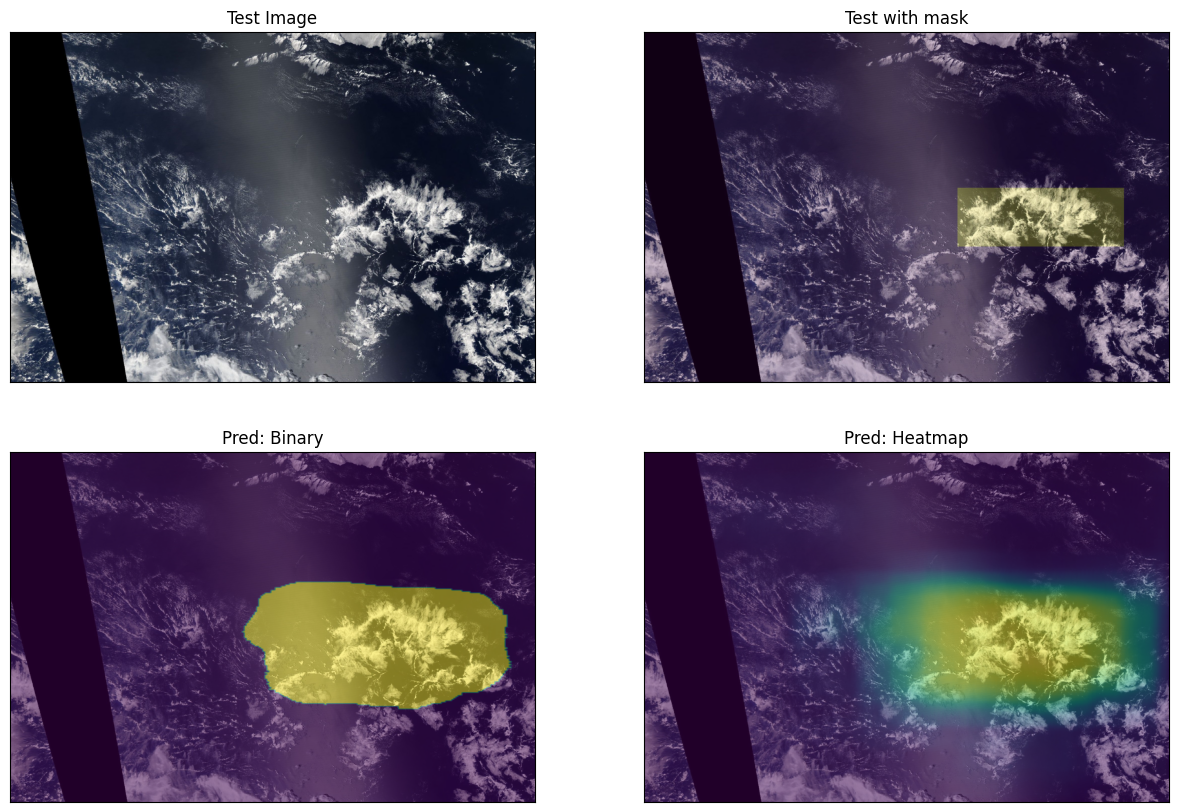

In [48]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1, xticks=[], yticks=[])
plt.imshow(image)
plt.title('Test Image')

ax = fig.add_subplot(2, 2, 2, xticks=[], yticks=[])
plt.imshow(image)
plt.imshow(mask, alpha=0.25)
plt.title('Test with mask')

ax = fig.add_subplot(2, 2, 3, xticks=[], yticks=[])
mask_resized = cv2.resize(
    mask_np,
    (image.width, image.height),
    interpolation=cv2.INTER_LINEAR
)
plt.imshow(image)
plt.imshow(mask_resized, alpha=0.5)
plt.title('Pred: Binary')

ax = fig.add_subplot(2, 2, 4, xticks=[], yticks=[])
mask_heatmap_resized = cv2.resize(
    mask_heatmap,
    (image.width, image.height),
    interpolation=cv2.INTER_LINEAR
)
plt.imshow(image)
plt.imshow(mask_heatmap_resized, alpha=0.5)
plt.title('Pred: Heatmap')